<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "PT-L5"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/PT-L5/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


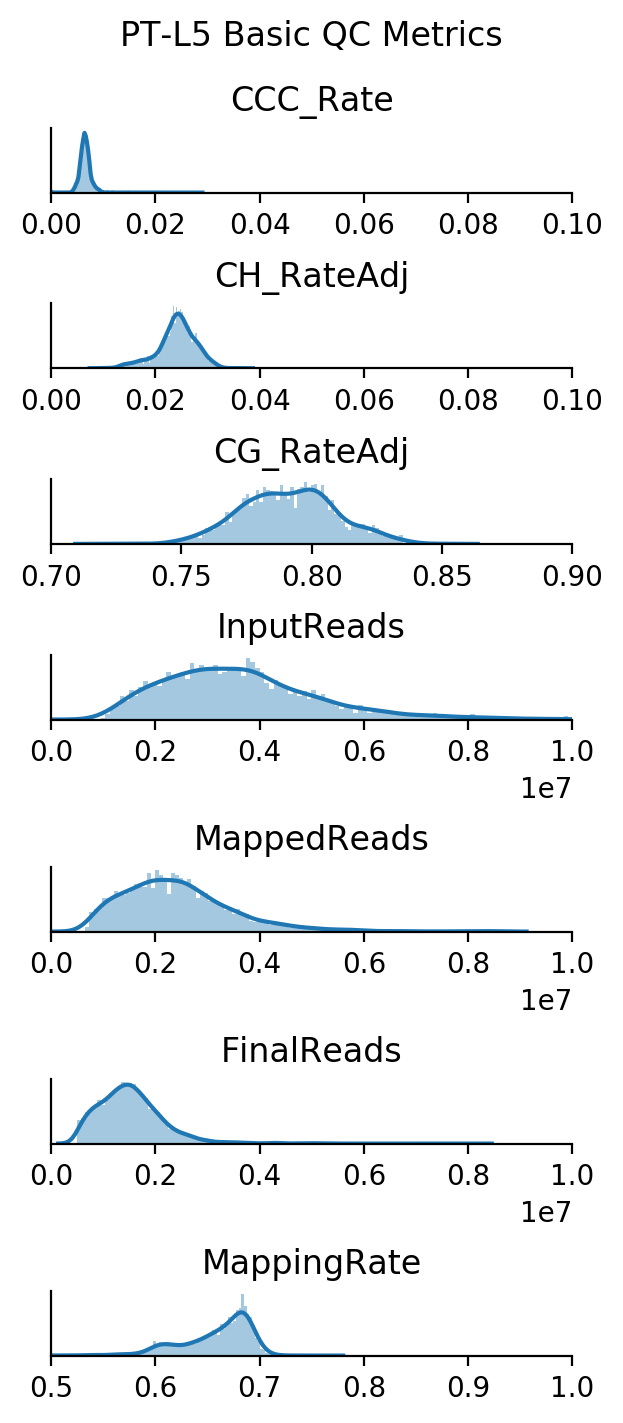

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

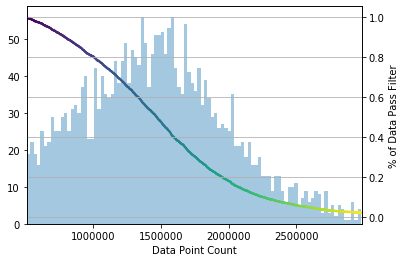

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2638/2638 (100.0%)
CG_RateAdj passed 2638/2638 (100.0%)
CH_RateAdj passed 2638/2638 (100.0%)
FinalReads passed 2638/2638 (100.0%)
MappingRate passed 2638/2638 (100.0%)
Overall passed 2638/2638 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 48
171207 45
171212 31
171213 37
171214 1
180104 41
180109 1
180119 52
180122 89
180123 122
180129 148
180130 114
180205 94
180206 117
180208 1
180213 61
180220 54
180222 32
180226 31
180227 15
180305 67
180306 61
180312 66
180313 1
180319 1
180320 7
180326 9
180329 3
180402 4
180403 3
180405 3
180409 29
180410 29
180412 59
180416 112
180417 33
180419 24
180423 49
180424 20
180426 38
180430 34
180501 58
180514 16
180529 22
180605 37
180612 60
180724 1
180917 104
181002 34
181009 10
181022 31
181023 32
181204 30
181210 40
190108 76
190117 45
190122 20
190124 28
190131 11
190205 110
190212 1
190214 7
190305 7
190307 69
190627 3


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 333 86.7%
ad002 331 86.2%
ad004 335 87.2%
ad006 344 89.6%
ad007 298 77.6%
ad008 319 83.1%
ad010 332 86.5%
ad012 346 90.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1737,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006698,0.800241,0.798894,0.030182,0.023643,630412.0,2183164,1284613.0,10E,...,-10.668567,-18.436256,9.323368,-22.833178,PT-L5,8.643658,7.802010,44.712395,12.111033,True
10E_M_1923,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006946,0.777097,0.775538,0.031242,0.024465,1617403.0,5071650,3011348.0,10E,...,-12.369898,-19.973391,12.122541,-26.110120,PT-L5,9.075079,9.692132,52.317990,20.639478,True
10E_M_2767,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006265,0.780622,0.779238,0.026516,0.020378,727352.0,3105538,1653928.0,10E,...,-10.816996,-18.481640,9.326729,-22.830440,PT-L5,8.769894,7.872361,44.762983,12.166444,True
11E_M_100,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006043,0.791108,0.789838,0.026546,0.020628,1840099.0,4574010,3116666.0,11E,...,-11.185349,-19.940174,7.441197,-22.131460,PT-L5,8.417069,8.858660,50.122727,18.170745,True
11E_M_1184,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.007393,0.789094,0.787523,0.033476,0.026276,554133.0,1355406,858297.0,11E,...,-10.742737,-18.618608,9.167432,-22.938807,PT-L5,8.598008,7.852602,44.681941,12.124142,True
11E_M_1713,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006145,0.787747,0.786435,0.028203,0.022194,1602360.0,3859182,2647540.0,11E,...,-11.534233,-19.821133,10.499289,-25.887154,PT-L5,8.585292,9.004346,50.275366,18.382099,True
11E_M_2359,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006414,0.806061,0.804809,0.031527,0.025275,1286761.0,2838124,1955173.0,11E,...,-9.335588,-19.091396,4.118455,-20.439742,PT-L5,6.791731,6.899999,38.936338,7.033565,True
11E_M_2606,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.007228,0.755212,0.753430,0.032563,0.025520,1257890.0,3057852,2029922.0,11E,...,-12.541379,-19.118937,12.834071,-31.589984,PT-L5,10.185852,8.691388,43.243238,25.674914,True
11E_M_2776,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.006771,0.776459,0.774935,0.032314,0.025717,1416244.0,3169988,2081403.0,11E,...,-9.302410,-18.897493,4.616207,-20.489173,PT-L5,6.733362,7.060102,39.308302,6.890907,True
